### Sizing ###


The appropriate sizing of a simulation space is often more art than science but we can use several tools in the RKnot package to ensure that any particular simulation has the appropriate attributes and initial conditions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shelve
file = 'tests/data/R0'
# db.close()
db = shelve.open(file, writeback=True)

In [3]:
import numpy as np

from rknot import Sim
from rknot.dots.matrix import ML, MLNB
from rknot.helpers import md, contacts_of_init_inf, find_n_sec

UPDATEDB = True

#### SIR: Confirming Contacts ####

For instance, in our [SIR-based simulations](sir.ipynb) with constant transmission risk, the SIR model is mostly faithfully replicated with a contact rate of 1 per day ... and [we have seen mathematically](theory.ipynb#Expected-Contact-Rate) that a density level of 1 dot per location should result in a contact rate of ~1 per day.

Below, we will investigate if, in fact, that is the case.

First, create a small population of 100 subjects with no movement bias and a single infected subject.

In [4]:
from rknot import Sim

group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='equal',
)

We will restrict the simulation to just 14 days. We set `dlevel=med`, which sets the population density to 1 subject per location.

In [5]:
params = dict(
    dlevel='med',
    R0=3,
    infdur=14,
    days=14,
)

When running the sim, set `dotlog=True`. The `dotlog` is 3d record of the dot matrix at each tick in the simulation. We can use it to test several things.

`dotlog` defaults to `False` as it can impact performance for large populations and longer simulations.

In [6]:
sim = Sim(groups=group, **params)
sim.run(dotlog=True)

In [7]:
msg = 'Upon completion of the sim, an attribute `dotlog` has been added. '
msg += 'We can see it has shape (14, 100, {}), corresponding to 14 ticks, 100 dots, '.format(sim.dotlog.shape[2])
msg += 'and the {} attributes in the dot matrix.'.format(sim.dotlog.shape[2])

md(msg)

Upon completion of the sim, an attribute `dotlog` has been added. We can see it has shape (14, 100, 23), corresponding to 14 ticks, 100 dots, and the 23 attributes in the dot matrix.

The initial infected dot is chosen at random, so we cannot isolate and track its movements ahead of time. But we *can* isolate it in the first first frame of the `dotlog` and review its entire history in the sim.

In [8]:
import numpy as np
from rknot.dots.matrix import ML, MLNB


i_inf = np.argwhere(sim.dotlog[0][:, ML['is_inf']] == 1).ravel()
sim.dotlog[:, i_inf]

array([[[ 64,   0,   1,   0,   0,   1,   1,  89,   9,  10,  40,   5,
           1,   0,   0,  -1,   0, 100,   0,   0,  -1,  15, 381]],

       [[ 64,   0,   1,   0,   0,   1,   1,  16,   2,   7,  40,   5,
           1,   0,   0,  -1,   0, 100,   0,   0,  -1,  15, 381]],

       [[ 64,   0,   1,   0,   0,   1,   1,  17,   2,   8,  40,   5,
           1,   0,   0,  -1,   0, 100,   0,   0,  -1,  15, 381]],

       [[ 64,   0,   1,   0,   0,   1,   1,   2,   1,   3,  40,   5,
           1,   0,   0,  -1,   0, 100,   0,   0,  -1,  15, 381]],

       [[ 64,   0,   1,   0,   0,   1,   1,  46,   5,   7,  40,   5,
           1,   0,   0,  -1,   0, 100,   0,   0,  -1,  15, 381]],

       [[ 64,   0,   1,   0,   0,   1,   1,  30,   4,   1,  40,   5,
           1,   0,   0,  -1,   0, 100,   0,   0,  -1,  15, 381]],

       [[ 64,   0,   1,   0,   0,   1,   1,  12,   2,   3,  40,   5,
           1,   0,   0,  -1,   0, 100,   0,   0,  -1,  15, 381]],

       [[ 64,   0,   1,   0,   0,   1,   1,   0,

We can then determine which locations the dot visited at each tick.

In [9]:
locs_visited = sim.dotlog[:, i_inf, ML['loc_id']].ravel()
locs_visited

array([89, 16, 17,  2, 46, 30, 12,  0, 68, 59, 31, 81, 81, 82])

In [10]:
db['locs_visited1'] = locs_visited

Next, find how many total dots were at the same location at the same time as the initial infected.

In [11]:
dots_at_loc = sim.dotlog[:,:,ML['loc_id']] == locs_visited[:, None]
dots_at_loc.sum(axis=1)

array([3, 2, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 4, 2])

In [12]:
db['dots_at_loc1'] = dots_at_loc

In [13]:
msg = 'The array above tells us there we {} dots '.format(db['dots_at_loc1'].sum(axis=1)[0])
msg += 'at location id {} on the first tick, '.format(db['locs_visited1'][0])
msg += '{} dots at '.format(db['dots_at_loc1'].sum(axis=1)[1])
msg += 'location id {} on the second tick, etc.'.format(db['locs_visited1'][1])

md(msg)

The array above tells us there we 3 dots at location id 89 on the first tick, 2 dots at location id 16 on the second tick, etc.

In [14]:
assert (sim.dotlog[0, :, ML['loc_id']] == db['locs_visited1'][0]).sum() == dots_at_loc.sum(axis=1)[0]
assert (sim.dotlog[1, :, ML['loc_id']] == db['locs_visited1'][1]).sum() == dots_at_loc.sum(axis=1)[1]

Again, the expected contact rate ~1 per day. First, we subtract 1 from `dots_at_loc` since a contact constitutes two or more dots. Then find the mean and variance of the infected dot's daily contacts.

In [15]:
contacts = dots_at_loc.sum(axis=1) - 1
mean = contacts.mean()
var = contacts.var()

In [16]:
if UPDATEDB:
    db['mean, var 1'] = (mean, var, contacts)
mean, var, contacts = db['mean, var 1']

In [17]:
print (round(mean, 2), round(var, 2))

0.86 0.84


The contact distribution is as follows:

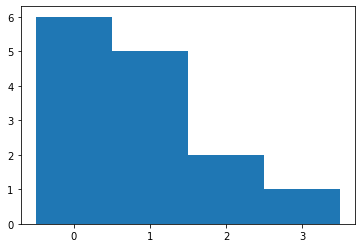

In [18]:
import matplotlib.pyplot as plt

plt.hist(contacts, bins=np.arange(contacts.max() + 2) - 0.5)
plt.xticks(range(contacts.max() + 1))
plt.show()

The contact rate is in range of the expected value of 1, but this example has a very small sample size. We can expand the sample by continuing to isolate the initial infected dot but increasing the simulation length. 

The code above has been factored into a helper function `contacts_of_init_inf`.

In [19]:
from rknot import Sim

params = dict(
    dlevel='med',
    R0=3,
    infdur=14,
    days=100,
)

sim = Sim(groups=group, **params)
sim.run(dotlog=True)

In [20]:
from rknot.helpers import contacts_of_init_inf

contacts = contacts_of_init_inf(sim.dotlog)
mean = np.mean(contacts)
var = np.var(contacts)

In [21]:
if UPDATEDB:
    db['mean, var 2'] = (mean, var, contacts)
mean, var, contacts =  db['mean, var 2']

In [22]:
print (mean, var)

1.1666666666666667 0.8055555555555555


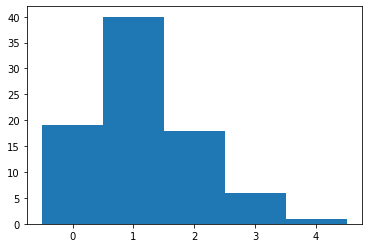

In [23]:
plt.hist(contacts, bins=np.arange(contacts.max() + 2) - 0.5)
plt.xticks(range(contacts.max() + 1))
plt.show()

Again, we find a similar average contact rate and variance, although histogram shape is altered somewhat.

For an even larger sample, we can repeat the above process for every dot in the simulation. The loop below gives us a record of every daily contact count for every dot in the sim.

In [24]:
from numba import njit, prange
from rknot.dots.matrix import MLNB

@njit(cache=True, parallel=True)
def find_all_contacts(dotlog, MLNB):
    days = dotlog.shape[0]
    n = dotlog.shape[1]
    all_contacts = np.zeros(days*n, dtype=np.int32)
    for i in prange(n):
        locs_visited = dotlog[:, i, MLNB['loc_id']]
        dots_at_loc = dotlog[:,:,MLNB['loc_id']] == locs_visited.copy().reshape(-1,1)
        contacts = dots_at_loc.sum(axis=1) - 1
        all_contacts[i*days:i*days+days] = contacts
    
    return all_contacts

all_contacts = find_all_contacts(sim.dotlog[:14], MLNB)
mean = all_contacts.mean()
var = all_contacts.var()

In [25]:
if UPDATEDB:
    db['mean, var 3'] = (mean, var, all_contacts)
mean, var, all_contacts = db['mean, var 3']

In [26]:
print (mean, var)

0.9571428571428572 0.8724489795918366


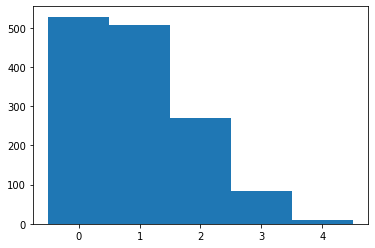

In [27]:
plt.hist(all_contacts, bins=np.arange(all_contacts.max() + 2) - 0.5, density=False)
plt.xticks(range(all_contacts.max() + 1))
plt.show()

We find that all the dots in the sim had a contact rate near 1 (as expected) and variance near 1.

Yet another approach would be to iterate over a number of different sims and look for the mean and variance of contacts for the infected dot across those sims.

In [33]:
from tqdm.auto import trange

days = 14
infdur = 14
n = 50
params = {'dlevel': 'med', 'R0': 3, 'infdur': infdur, 'days': days}

contacts = np.zeros(days*n, dtype=np.int32)
for i in trange(n):
    sim = Sim(groups=group, **params)
    sim.run(dotlog=True, pbar_on=False)
    inf_contacts = contacts_of_init_inf(sim.dotlog)
    contacts[i*days:i*days + days] = inf_contacts

mean, var = contacts.mean(), contacts.var()

In [34]:
if UPDATEDB:
    db['mean, var 3'] = (mean, var, contacts)
mean, var, contacts = db['mean, var 3']

In [35]:
print (contacts.mean(), contacts.reshape(-1,14).sum(axis=1).mean())

1.0114285714285713 14.16


Above we see that the infected dot average close to 1 contact per day or 14 contacts over the duration of the infection.

#### SIR: Confirming $R_0$ ####

We can similarly use the dotlog to confirm that the simulation results in the correct level of $R_0$, whether passed explicitly or implied through other parameters.

In [36]:
params = dict(
    dlevel='med',
    R0=3,
    infdur=14,
    days=20,
)

sim = Sim(groups=group, **params)
sim.run(dotlog=True)

Again, we can find the ids that had contact with the infected dot at each tick.

In [37]:
i_inf = np.argwhere(sim.dotlog[0][:, ML['is_inf']] == 1).ravel()
locs_visited = sim.dotlog[:, i_inf, ML['loc_id']].ravel()
dots_at_loc = sim.dotlog[:,:,ML['loc_id']] == locs_visited[:, None]

Now, we will check each dots' `is_inf` attribute *before* and *after* the contact occurs.

Remember, transmission is the last step in each tick and that the dot matrix is update at the beginning of each tick. So, the status of the dot at tick i is its status *before* contact.

We sum the dots infected before and subtract the dots infected after, which gives the dots infected at that contact.

In [38]:
i_contact = np.argwhere(dots_at_loc) # ids of each dot at each location
i_contact = i_contact[i_contact[:,1] != i_inf] # excludes the initial infected dot

# the infection status of each dot, before each contact
infs_pre = sim.dotlog[i_contact[:, 0], i_contact[:, 1], ML['is_inf']].sum() 

fwd_inf = i_contact + [1, 0] # shift the ticks for each contact one tick forward
fwd_mask = fwd_inf[:, 0] < sim.ticks 

# the infection status of each dot, after each contact
infs_post = sim.dotlog[fwd_inf[fwd_mask][:,0], fwd_inf[fwd_mask][:,1], ML['is_inf']].sum()

# Number of secondary infections created by the initial infected dot
n_sec = infs_post - infs_pre

In [39]:
if UPDATEDB:
    db['nsec 1 run'] = n_sec
n_sec = db['nsec 1 run']

In [40]:
msg = 'The sim above resulted in {} infections.'.format(n_sec)
md(msg)

The sim above resulted in 5 infections.

Again, transmission is stochastic. We can find a more useful mean by averaging the $R_0$ over several simulations.

The code used above has been factored into the function `find_n_sec`.

In [41]:
from rknot.helpers import find_n_sec

days = 20
infdur = 14
n = 100
params = {'dlevel': 'med', 'R0': 3, 'infdur': infdur, 'days': days}

contacts = np.zeros(infdur*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    sim = Sim(groups=group, **params)
    sim.run(dotlog=True, pbar_on=False)
    n_secs[i] = find_n_sec(sim.dotlog[:infdur+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:infdur])
    contacts[i*infdur:i*infdur + infdur] = inf_contacts

mean, var = n_secs.mean(), n_secs.var()

In [42]:
if UPDATEDB:
    db['nsecs mean, var 1'] = (n_secs.mean(), n_secs.var(), contacts)
mean, var, contacts = db['nsecs mean, var 1']

In [43]:
print (mean, var, contacts[:infdur*n].reshape(-1,14).sum(axis=1).mean())

2.42 2.2036000000000002 13.79


We can see that the $R_0$ resulting in the sims, on average, is relatively close to the $R_0$ provided.

#### SIR: Impact of Changes in Mover Function ###

With the veracity of the SIR model and the assessment process confirmed, we can check the impact of changes to various attributes of the sim, including the `mover` function.

In [44]:
group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='local',
)
days = 20
infdur = 14
params = {'dlevel': 'med', 'R0': 3, 'infdur': infdur, 'days': days}

n = 20
contacts = np.zeros(infdur*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    sim = Sim(groups=group, **params)
    sim.run(dotlog=True, pbar_on=False)
    n_secs[i] = find_n_sec(sim.dotlog[:infdur+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:infdur])
    contacts[i*infdur:i*infdur + infdur] = inf_contacts
    
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = n_secs.mean(), n_secs.var()

In [45]:
if UPDATEDB:
    db['contacts mean, var local'] = (contacts.mean(), contacts.var())
    db['nsecs mean, var local'] = (n_secs.mean(), n_secs.var())

mean_ktr, var_ktr = db['contacts mean, var local']
mean_nsec, var_nsec = db['nsecs mean, var local']

In [46]:
print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)

0.9607142857142857 0.9305994897959183
2.9 2.59


Despite the signficant change in movement pattern, [which we know results in a very different infection curve](sir.ipynb#1.-Local), the $R_0$ is only slightly different than that predicted under SIR conditions.

#### Customization ####

We can use this testing approach to structure simulation space to fit a set of desired properties.

For example, in this [paper](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf), the authors fit a transmission risk profile of the virus to several properties of the environment including:
+ mean $R_0$ of 1.8
+ 4 contacts per day
+ 40 variance of contacts


We can import the tmr curve from `rknot.dots.fhutch`.

We will pass a density level of 4 dots per location (which will lead to ~4 contacts per day) and we extend the simulation to 21 days, given the `tmr` curve has shape 20.

In [47]:
from rknot.dots.fhutch import tmr

group = dict(
    name='all',
    n=100,
    n_inf=1,
    ifr=0,
    mover='equal',
)

days = 21
infdur = 14
params = {'dlevel': 4, 'R0': 3, 'inf_curve': tmr,  'days': days}

n = 100
contacts = np.zeros(infdur*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    sim = Sim(groups=group, **params)
    sim.run(dotlog=True, pbar_on=False)
    n_secs[i] = find_n_sec(sim.dotlog[:infdur+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:infdur])
    contacts[i*infdur:i*infdur + infdur] = inf_contacts
    
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = n_secs.mean(), n_secs.var()

In [48]:
if UPDATEDB:
    db['contacts mean, var 2'] = (contacts.mean(), contacts.var())
    db['nsecs mean, var 2'] = (n_secs.mean(), n_secs.var())

mean_ktr, var_ktr = db['contacts mean, var 2']
mean_nsec, var_nsec = db['nsecs mean, var 2']

In [49]:
print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)

3.9957142857142856 3.8985530612244905
1.98 2.4196


The $R_0$ is close to the expected value of 1.8. We can also see that the contact rate is close to 4, however, the variance is well below the required 40.

RKnot's event based structure (which more closely mimicks real world movement pattern) can help us increase the variance of contacts. 

We will use the root [`baseus` structure](constant.ipynb#sir) to work with a larger population.

Because we are adding many larger events, we should be able to tune down the density level, but still reach the average 4 contacts per day level. Below we will use `dlevel=3.5`.

We also augment the events so that they fit inside the grid space.

In [50]:
from rknot.events import Event
from rknot.sims import baseus

groups = baseus.groups
groups[2]['n_inf'] = 0

school1 = Event(name='school1', xy=[25,42], start_tick=2, groups=[0], capacity=25, recurring=2)
school2 = Event(name='school2', xy=[34,16], start_tick=3, groups=[0], capacity=50, recurring=2)
school3 = Event(name='school3', xy=[47,28], start_tick=4, groups=[0], capacity=25, recurring=2)
game1 = Event(name='game1', xy=[50,39], start_tick=6, groups=[0,1,2,3], capacity=100, recurring=14)
game2 = Event(name='game2', xy=[24,25], start_tick=5, groups=[0,1,2], capacity=76, recurring=14)
game3 = Event(name='game3', xy=[6,43], start_tick=1, groups=[0,1,2], capacity=56, recurring=14)
game4 = Event(name='game4', xy=[26,53], start_tick=3, groups=[1,2], capacity=113, recurring=28)
concert1 = Event(name='concert1', xy=[10,10], start_tick=7, groups=[0,1], capacity=50, recurring=14)                 
concert2 = Event(name='concert2', xy=[53,46], start_tick=3, groups=[1], capacity=50, recurring=14)
concert3 = Event(name='concert3', xy=[31,19], start_tick=1, groups=[2,3], capacity=25, recurring=14)
concert4 = Event(name='concert4', xy=[19,21], start_tick=5, groups=[1,2], capacity=50, recurring=28)
concert5 = Event(name='concert5', xy=[19,20], start_tick=3, groups=[1,2], capacity=25, recurring=21)
concert6 = Event(name='concert6', xy=[8,41], start_tick=5, groups=[1,2], capacity=50, recurring=28)
concert7 = Event(name='concert7', xy=[1,21], start_tick=2, groups=[0,1,2], capacity=125, recurring=14)
bar1 = Event(name='bar1', xy=[9,12], start_tick=4, groups=[1], capacity=5, recurring=3)
bar2 = Event(name='bar2', xy=[49,9], start_tick=5, groups=[1], capacity=5, recurring=4)
bar3 = Event(name='bar3', xy=[26,45], start_tick=6, groups=[1,2], capacity=5, recurring=3)
bar4 = Event(name='bar4', xy=[8,14], start_tick=7, groups=[1,2,3], capacity=4, recurring=7)
church = Event(name='church', xy=[2,51], start_tick=7, groups=[2,3], capacity=20, recurring=7)

events = [
    school1, school2, school3, game1, game2, game3, game4, 
    concert1, concert2, concert3, concert4, concert5, concert6, concert7,
    bar1, bar2, bar3, bar4,
    church
]

In [51]:
days = 21
params = dict(
    days=days,
    inf_curve=tmr,
    dlevel=3.5,
    imndur=365,
)

In [52]:
length = tmr.shape[0]
n = 100
contacts = np.zeros(length*n, dtype=np.int32)
n_secs = np.zeros(n, dtype=np.int32)
for i in trange(n):
    sim = Sim(groups=groups, events=events, **params)
    sim.run(dotlog=True, pbar_on=False)
    n_secs[i] = find_n_sec(sim.dotlog[:length+1])
    inf_contacts = contacts_of_init_inf(sim.dotlog[:length])
    contacts[i*length:i*length + length] = inf_contacts
    
mean_ktr, var_ktr = contacts.mean(), contacts.var()
mean_nsec, var_nsec = n_secs.mean(), n_secs.var()

In [53]:
if UPDATEDB:
    db['contacts mean, var 4'] = (contacts.mean(), contacts.var())
    db['nsecs mean, var 4'] = (n_secs.mean(), n_secs.var())

mean_ktr, var_ktr = db['contacts mean, var 4']
mean_nsec, var_nsec = db['nsecs mean, var 4']

In [57]:
groups

[{'name': '0-19', 'n': 2700, 'n_inf': 0, 'ifr': 3e-05, 'mover': 'local'},
 {'name': '20-49', 'n': 4100, 'n_inf': 1, 'ifr': 0.0002, 'mover': 'local'},
 {'name': '50-69', 'n': 2300, 'n_inf': 0, 'ifr': 0.005, 'mover': 'local'},
 {'name': '70+', 'n': 900, 'n_inf': 0, 'ifr': 0.054, 'mover': 'local'}]

In [54]:
print (mean_ktr, var_ktr)
print (mean_nsec, var_nsec)

3.899 49.89179899999999
1.96 5.538399999999999


We can see this simulation fits the FREDHUTCH model quite nicely. This space is used as the base structure for the [experiments in viral load found here.](load.ipynb#Events).

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [56]:
from rknot.helpers import move_to_doc_folder
move_to_doc_folder('sizing.ipynb')